# NOTE!!!
- This is still in the context of tripadvisor reviews of waterfront
- when the datasets are complete (i.e. naa na ang data from other sites sa kana nga hotel), kay cleaning & preprocessing of data should be adjusted when loading the different .csv files and the naming convention sa preprocessed reviews.
- ^^ Example: `preprocessed_waterfront_reviews_booking.npz`, `preprocessed_waterfront_reviews_agoda.npz`, `preprocessed_waterfront_reviews_tripadvisor.npz`, `preprocessed_waterfront_reviews_klook.npz`
- for automation of processes, add a feat where you just type in the name of the hotel and it will automatically search and load up the necessary CSVs for that inputted hotel.
- all ratings will be normalized before sentiment analysis to a [0, 1] range

## Current issues:
- model is abnormal. it outputs all 1.0 no matter the negative threshold.
- model needs work

## Importing libraries

In [13]:
# Importing Libraries
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import nltk
import glob
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate

# Download NLTK resources
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Cleaning & Preprocessing of data

In [14]:
# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 10

# Load the dataset
hotel_reviews_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\tripadvisor\1_Waterfront-Cebu-City-Hotel-Casino.csv"
hotel_reviews = pd.read_csv(hotel_reviews_path)

# Remove irrelevant columns
columns_to_keep = ['Review Text', 'Rating', 'Review Date']
hotel_reviews = hotel_reviews[columns_to_keep]

# Remove missing values
hotel_reviews.dropna(subset=['Review Text', 'Rating'], inplace=True)

# Extract numeric rating from textual ratings (if necessary)
def extract_numeric_rating(rating):
    if isinstance(rating, str):
        match = re.search(r'(\d+(\.\d+)?)', rating)
        if match:
            return float(match.group(1))
    return rating

hotel_reviews['Rating'] = hotel_reviews['Rating'].apply(extract_numeric_rating)

# Normalize ratings to a common scale (0 to 1)
scaler = MinMaxScaler(feature_range=(0, 1))
hotel_reviews['Rating'] = scaler.fit_transform(hotel_reviews[['Rating']])

# Language detection and filtering for English reviews
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

hotel_reviews = hotel_reviews[hotel_reviews['Review Text'].apply(is_english)]

# Remove HTML tags
hotel_reviews['Review Text'] = hotel_reviews['Review Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

# Remove duplicates
hotel_reviews.drop_duplicates(subset=['Review Text'], inplace=True)

# Text preprocessing: convert to lowercase, remove punctuation, and stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

hotel_reviews['Review Text'] = hotel_reviews['Review Text'].apply(preprocess_text)

# Verify the preprocessing steps
print(hotel_reviews.head())

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(hotel_reviews['Review Text'])
sequences = tokenizer.texts_to_sequences(hotel_reviews['Review Text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
labels = hotel_reviews['Rating'].values

# Split data into training and testing sets (70/30)
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

# Create the processed reviews folder if it doesn't exist
output_dir = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\processed_reviews"
os.makedirs(output_dir, exist_ok=True)

# Save the preprocessed and vectorized dataset along with indices
output_path = os.path.join(output_dir, "preprocessed_waterfront_reviews.npz")
np.savez_compressed(output_path, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, x_test_indices=np.arange(len(x_test)))

# Verify shapes
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Empty DataFrame
Columns: [Review Text, Rating, Review Date]
Index: []


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## Data preparation

In [ ]:
# Path to the preprocessed and vectorized dataset
preprocessed_data_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\processed_reviews\preprocessed_waterfront_reviews.npz"

# Verify and load clean and preprocessed hotel review data
if not os.path.exists(preprocessed_data_path):
    raise FileNotFoundError(f"File not found: {preprocessed_data_path}")

# Load the preprocessed data
data = np.load(preprocessed_data_path)
x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

# Verify shapes
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Load aspect data from all CSV files
aspect_files = glob.glob(r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\aspect-based\*.csv")
aspect_reviews = []
aspect_labels = []

for file in aspect_files:
    df = pd.read_csv(file)
    aspect_reviews.extend(df['Opinion'].tolist())
    df['Classification'] = df['Classification'].fillna('').astype(str)
    aspect_labels.extend(df['Classification'].apply(lambda x: x.split(':') if ':' in x else [x]).tolist())

# Tokenize and pad sequences for aspect reviews
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(aspect_reviews)
sequences_aspect = tokenizer.texts_to_sequences(aspect_reviews)
aspect_data = pad_sequences(sequences_aspect, maxlen=MAX_SEQUENCE_LENGTH)

# Convert aspect labels to one-hot encoded format
mlb = MultiLabelBinarizer()
aspect_labels = mlb.fit_transform(aspect_labels)

# Split aspect data into training and validation sets (purely for training)
x_train_aspects, x_val_aspects, y_train_aspects, y_val_aspects = train_test_split(aspect_data, aspect_labels, test_size=0.3, random_state=42)

# Check the shapes of the split data
print(f"x_train_aspects shape: {x_train_aspects.shape}")
print(f"x_val_aspects shape: {x_val_aspects.shape}")
print(f"y_train_aspects shape: {y_train_aspects.shape}")
print(f"y_val_aspects shape: {y_val_aspects.shape}")


x_train shape: (1206, 200)
x_test shape: (517, 200)
y_train shape: (1206,)
y_test shape: (517,)
x_train_aspects shape: (6038, 200)
x_val_aspects shape: (2588, 200)
y_train_aspects shape: (6038, 8)
y_val_aspects shape: (2588, 8)


## EDA

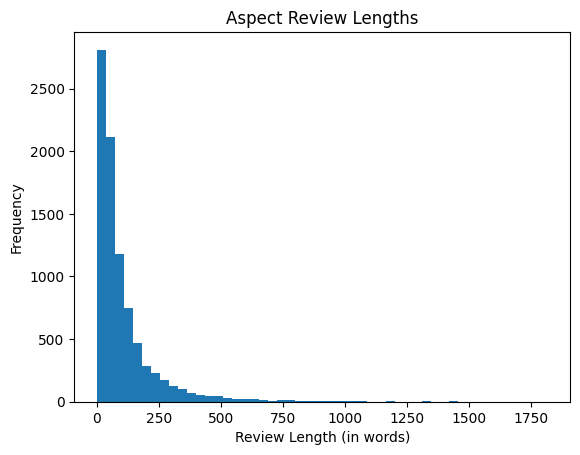

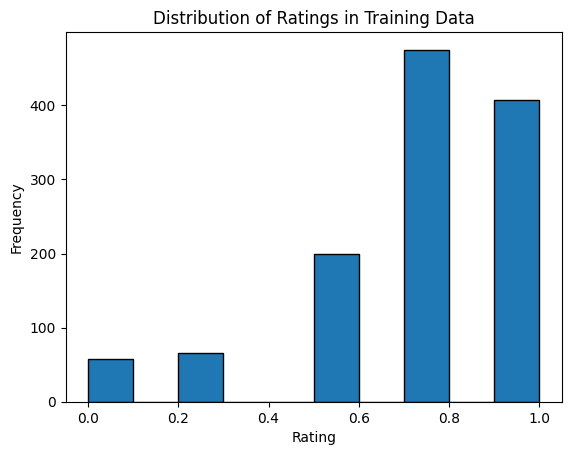

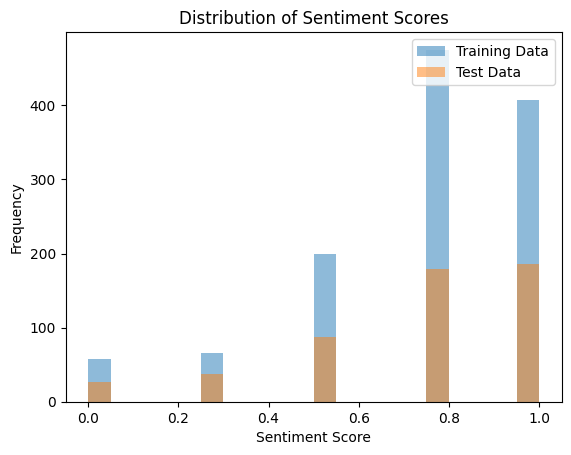

In [ ]:
#* NOTE: for EDA purposes only
review_lengths = [len(review.split()) for review in aspect_reviews]
plt.hist(review_lengths, bins=50)
plt.title('Aspect Review Lengths')
plt.xlabel('Review Length (in words)')
plt.ylabel('Frequency')
plt.show()


plt.hist(y_train, bins=10, edgecolor='k')
plt.title("Distribution of Ratings in Training Data")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Plot the distribution of sentiment scores
plt.hist(y_train, bins=20, alpha=0.5, label='Training Data')
plt.hist(y_test, bins=20, alpha=0.5, label='Test Data')
plt.legend(loc='upper right')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

## Model training part

In [ ]:
#! OLD VERSION OF MODEL CODE
# # Calculate class weights
# class_weights = class_weight.compute_class_weight('balanced', 
#                                                   classes=np.unique(y_train), 
#                                                   y=y_train)

# # Create a dictionary to use in model training
# class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# # Compute sample weights
# sample_weights = np.array([class_weights_dict[int(y)] for y in y_train])

# # Define the model architecture with Dropout
# input_text = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_text)
# conv = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding)
# pool = MaxPooling1D(pool_size=2)(conv)
# bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(pool)
# dropout = Dropout(0.5)(bi_lstm)
# flat = Flatten()(dropout)

# # Output layer for general sentiment
# sentiment_output = Dense(1, activation='sigmoid', name='sentiment_output')(flat)

# # Output layer for aspect-based sentiment
# aspect_output = Dense(len(mlb.classes_), activation='softmax', name='aspect_output')(flat)

# # Define the model
# model = Model(inputs=input_text, outputs=[sentiment_output, aspect_output])

# # Compile the model with mean squared error loss for sentiment analysis
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss={'sentiment_output': 'mse', 'aspect_output': 'categorical_crossentropy'},
#               metrics={'sentiment_output': 'mae', 'aspect_output': 'accuracy'})

# # Callback to monitor training
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.weights.h5', save_best_only=True, save_weights_only=True)
# ]

# # Train the model using aspect-based data for aspect prediction
# print("Training the model using aspect-based data for aspect prediction...")
# model.fit(x_train_aspects,
#           {'sentiment_output': np.zeros(len(x_train_aspects)), 'aspect_output': y_train_aspects},
#           validation_data=(x_val_aspects, {'sentiment_output': np.zeros(len(x_val_aspects)), 'aspect_output': y_val_aspects}),
#           epochs=EPOCHS,
#           batch_size=BATCH_SIZE,
#           callbacks=callbacks)

# # Train the model using hotel reviews for general sentiment prediction
# print("Training the model using hotel reviews for general sentiment prediction...")
# history = model.fit(x_train,
#                     {'sentiment_output': y_train, 'aspect_output': np.zeros((len(x_train), len(mlb.classes_)))},
#                     validation_data=(x_test, {'sentiment_output': y_test, 'aspect_output': np.zeros((len(x_test), len(mlb.classes_)))}),
#                     epochs=EPOCHS,
#                     batch_size=BATCH_SIZE,
#                     callbacks=callbacks,
#                     sample_weight=sample_weights)

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

Training CNN-biLSTM Model...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.2969 - loss: 0.6237 - val_accuracy: 0.3306 - val_loss: 0.5625
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3484 - loss: 0.5405 - val_accuracy: 0.3388 - val_loss: 0.5181
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3965 - loss: 0.4421 - val_accuracy: 0.3388 - val_loss: 0.5191
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3884 - loss: 0.4102 - val_accuracy: 0.3471 - val_loss: 0.5378
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3660 - loss: 0.4113 - val_accuracy: 0.3471 - val_loss: 0.5542
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3882 - loss: 0.3917 - val_accuracy: 0.3471 - val_loss: 0.5238
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3977 - loss: 0.3793 - val_accuracy: 0.3471 - val_loss: 0.5349
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4013 - loss: 0.3709 - val_accuracy: 0.3471 - val_loss: 0.

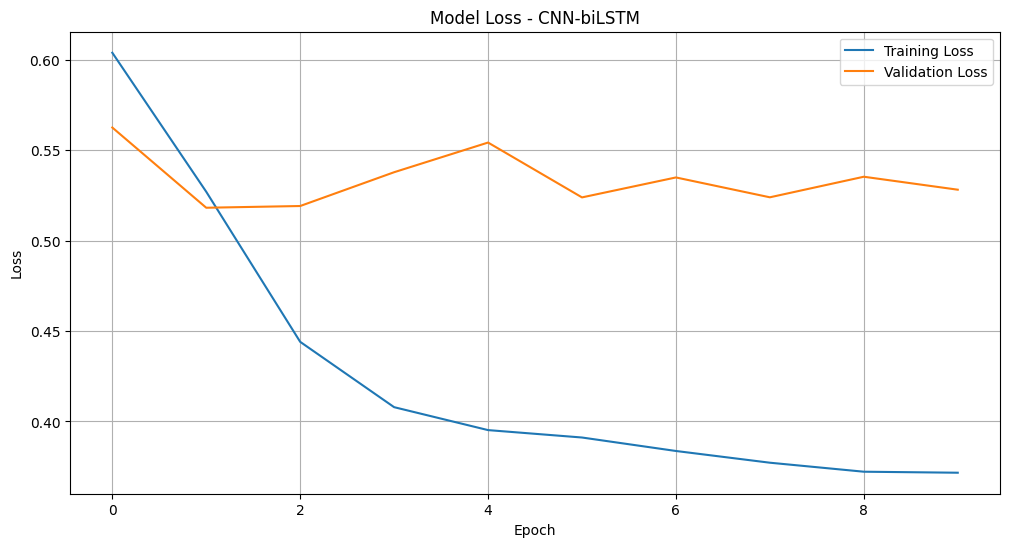

In [ ]:
# Model Training - CNN-biLSTM
print("Training CNN-biLSTM Model...")
input_text = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_text)
conv1d = Conv1D(128, 5, activation='relu')(embedding)
maxpool = MaxPooling1D(2)(conv1d)
bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(maxpool)
dropout = Dropout(0.5)(bi_lstm)
flat = Flatten()(dropout)
sentiment_output = Dense(1, activation='sigmoid')(flat)
model = Model(inputs=input_text, outputs=sentiment_output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and save the history
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - CNN-biLSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Training Aspect-Based biLSTM Model...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.1948 - loss: 5.1039 - val_accuracy: 0.2577 - val_loss: 4.7572
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.2382 - loss: 6.2677 - val_accuracy: 0.2577 - val_loss: 5.1907
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.2421 - loss: 6.8519 - val_accuracy: 0.2577 - val_loss: 5.5508
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 30s 157ms/step - accuracy: 0.2337 - loss: 7.2597 - val_accuracy: 0.2577 - val_loss: 5.9433
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - accuracy: 0.2350 - loss: 7.7879 - val_accuracy: 0.2577 - val_loss: 6.2956
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.2537 - loss: 8.1178 - val_accuracy: 0.2577 - val_loss: 6.6436
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.2446 - loss: 8.7803 - val_accuracy: 0.2577 - val_loss: 7.0497
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.2435 - loss: 8.7961 - val_a

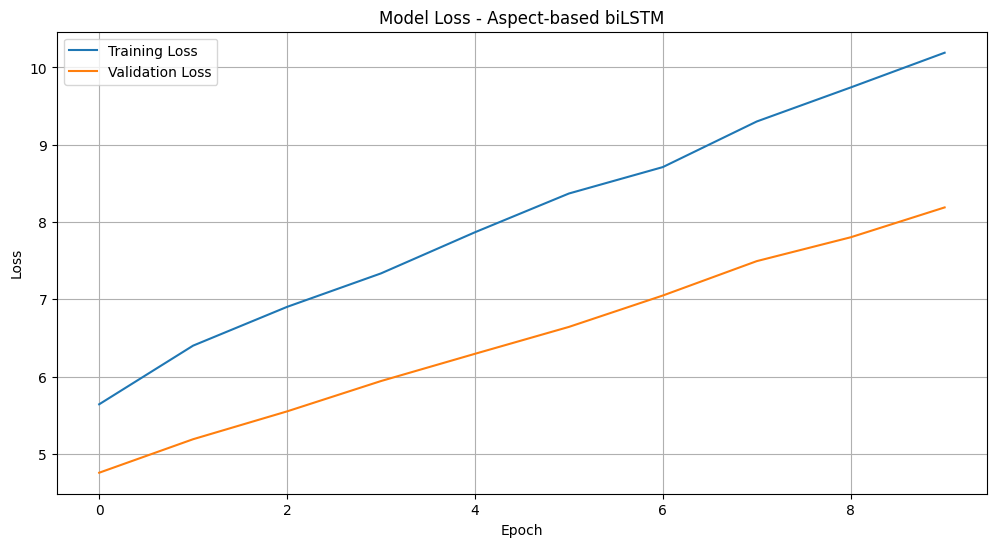

In [ ]:
# Model Training - Aspect-Based biLSTM
print("Training Aspect-Based biLSTM Model...")

# Load Aspect Data
aspect_files = glob.glob(r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\aspect-based\*.csv")
aspect_data = pd.concat((pd.read_csv(file) for file in aspect_files), ignore_index=True)

# Ensure all entries in 'Classification' are strings and handle missing values
aspect_data['Classification'] = aspect_data['Classification'].fillna('')  # Replace NaN with empty strings
aspect_data['Classification'] = aspect_data['Classification'].apply(lambda x: x.split(':') if isinstance(x, str) else [])

# Binarize labels
mlb = MultiLabelBinarizer()
aspect_labels = mlb.fit_transform(aspect_data['Classification'])

# Tokenize and pad sequences
aspect_reviews = tokenizer.texts_to_sequences(aspect_data['Opinion'])
aspect_reviews_padded = pad_sequences(aspect_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Split Aspect Data
x_train_aspects, x_test_aspects, y_train_aspects, y_test_aspects = train_test_split(aspect_reviews_padded, aspect_labels, test_size=0.3, random_state=42)

# Define Model
input_aspect = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_aspect = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_aspect)
bi_lstm_aspect = Bidirectional(LSTM(64, return_sequences=False))(embedding_aspect)
dropout_aspect = Dropout(0.5)(bi_lstm_aspect)
output_aspect = Dense(mlb.classes_.shape[0], activation='softmax')(dropout_aspect)
model = Model(inputs=input_aspect, outputs=output_aspect)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_aspects, y_train_aspects, validation_data=(x_test_aspects, y_test_aspects),
                    epochs=EPOCHS, batch_size=BATCH_SIZE)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - Aspect-based biLSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Checking of.npz file contents

In [ ]:
# Load the .npz file
general_sentiment_preds_file_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\processed_reviews\results\waterfront_general_sentiment_predictions.npz"
general_sentiment_preds_data = np.load(general_sentiment_preds_file_path)

preprocessed_reviews_file_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\processed_reviews\preprocessed_waterfront_reviews.npz"
preprocessed_reviews_data = np.load(preprocessed_reviews_file_path)

# Display the contents of the .npz file
print("Contents of the waterfront_general_sentiment_predictions.npz file:")
print(general_sentiment_preds_data.files)

# Convert the arrays to pandas DataFrames for tabular display
for array_name in general_sentiment_preds_data.files:
    array_data = general_sentiment_preds_data[array_name]
    print(f"\nArray Name: {array_name}")
    
    if array_data.ndim == 1:
        df = pd.DataFrame(array_data, columns=[array_name])
    else:
        df = pd.DataFrame(array_data)
    
        # Filter and display rows where the values are not 1.0
    filtered_df = df[df.iloc[:, 0] != 1.0]
    if not filtered_df.empty:
        print(f"\nFiltered {array_name} values that are not 1.0:")
        print(filtered_df.head())  # Display the first few rows of the filtered DataFrame
    else:
        print(f"\nNo values in {array_name} are different from 1.0")


# Display the contents of the .npz file
print("\nContents of the preprocessed_waterfront_reviews.npz file:")
print(preprocessed_reviews_data.files)

# Convert the arrays to pandas DataFrames for tabular display
for array_name in preprocessed_reviews_data.files:
    array_data = preprocessed_reviews_data[array_name]
    print(f"\nArray Name: {array_name}")
    
    if array_data.ndim == 1:
        df = pd.DataFrame(array_data, columns=[array_name])
    else:
        df = pd.DataFrame(array_data)
    
    print(df.head())  # Display the first few rows of the DataFrame

Contents of the waterfront_general_sentiment_predictions.npz file:
['sentiment_predictions']

Array Name: sentiment_predictions

Filtered sentiment_predictions values that are not 1.0:
   sentiment_predictions
0               0.999454

Contents of the preprocessed_waterfront_reviews.npz file:
['x_train', 'x_test', 'y_train', 'y_test', 'x_test_indices']

Array Name: x_train
   0    1    2    3    4    5    6    7    8    9    ...   190   191   192  \
0    0    0    0    0    0    0    0    0    0    0  ...     8  4894   346   
1    0    0    0    0    0    0    0    0    0    0  ...    54  6586   144   
2    0    0    0    0    0    0    0    0    0    0  ...  2292   800    92   
3    0    0    0    0    0    0    0    0    0    0  ...    96    39    14   
4    0    0    0    0    0    0    0    0    0    0  ...    11   247  1689   

    193  194   195   196  197   198  199  
0     3    4     1  1066  426  4895  536  
1    54    4  2843    13  215    66  135  
2    15   93   310   172  

## Statictical Analysis

In [ ]:
# Load sentiment predictions
predictions_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\processed_reviews\results\waterfront_general_sentiment_predictions.npz"
data = np.load(predictions_path, allow_pickle=True)
sentiment_predictions = data['sentiment_predictions']

# Load the original review texts
original_review_texts_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\tripadvisor\1_Waterfront-Cebu-City-Hotel-Casino.csv"
original_reviews_df = pd.read_csv(original_review_texts_path)

# Load indices
preprocessed_data_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\processed_reviews\preprocessed_waterfront_reviews.npz"
indices_data = np.load(preprocessed_data_path)
x_test_indices = indices_data['x_test_indices']

print(f"Number of sentiment predictions: {len(sentiment_predictions)}")
print(f"Number of indices: {len(x_test_indices)}")

if len(sentiment_predictions) != len(x_test_indices):
    raise ValueError("The number of sentiment predictions does not match the number of indices.")

# Align data using indices
aligned_reviews_df = original_reviews_df.iloc[x_test_indices]

# Combine sentiment predictions with aligned review texts
waterfront_reviews = pd.DataFrame({
    'Review Text': aligned_reviews_df['Review Text'],
    'SA': sentiment_predictions.flatten()
})

# Ensure no length issues
if len(waterfront_reviews) != len(sentiment_predictions):
    raise ValueError("Mismatch between aligned reviews and sentiment predictions.")


# Combine sentiment predictions with review texts
waterfront_reviews = pd.DataFrame({'Review Text': original_reviews_df['Review Text'], 'SA': sentiment_predictions.flatten()})

# Define a function to plot KDE and peak using statsmodels
def plot_sa_distribution(df, hotel_name):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df['SA'], shade=True, color='blue', label='SA Distribution')
    plt.title(f'Sentiment Analysis Distribution for {hotel_name}')
    plt.xlabel('Sentiment Analysis Score')
    plt.ylabel('Density')

    # Calculate KDE using statsmodels
    kde = KDEUnivariate(df['SA'])
    kde.fit(kernel='gau', bw='scott', gridsize=1000)
    density_values = kde.density
    support = kde.support
    peak_value = support[density_values.argmax()]
    plt.axvline(x=peak_value, linestyle='--', color='green', label=f'Peak: {round(peak_value, 2)}')

    # Add quartile lines
    quartile_ranges = {'Q1': (-1.0, -0.5), 'Q2': (-0.5, 0.0), 'Q3': (0.0, 0.5), 'Q4': (0.5, 1.0)}
    for label, (start, end) in quartile_ranges.items():
        plt.axvline(x=start, linestyle='--', color='red', label=f'{label}: {start} - {end}')
        plt.axvline(x=end, linestyle='--', color='red')

    plt.legend()
    plt.grid(True)
    plt.show()

    return peak_value

def save_results(hotel_name, peak_value):
    output_folder = "statistical_model_results"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Create a file path for saving the results
    output_filename = os.path.join(output_folder, f"{hotel_name}_results.txt")

    # Determine which quartile the peak belongs to
    quartile_ranges = {'Q1': (-1.0, -0.5), 'Q2': (-0.5, 0.0), 'Q3': (0.0, 0.5), 'Q4': (0.5, 1.0)}
    peak_quartile = None
    for label, (start, end) in quartile_ranges.items():
        if start <= peak_value <= end:
            peak_quartile = label
            break

    # Open the file in write mode and save the results
    with open(output_filename, "w") as file:
        file.write(f"{hotel_name} Peak Value: {peak_value}\n")
        file.write(f"{hotel_name} Peak Quartile Classification: {peak_quartile}\n")

# Plot KDE and peak for Waterfront Hotel
waterfront_peak_value = plot_sa_distribution(waterfront_reviews, 'Waterfront Hotel')

# Save the results
save_results("Waterfront Hotel", waterfront_peak_value)

Number of sentiment predictions: 1
Number of indices: 517


ValueError: The number of sentiment predictions does not match the number of indices.

## Additional EDA

In [ ]:
# Predict sentiment on the test set
sentiment_predictions_binary = (sentiment_predictions > 0.5).astype(int)
y_test_binary = (y_test > 0.5).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_binary, sentiment_predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_binary, sentiment_predictions_binary, target_names=['Negative', 'Positive'])
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[  0 152]
 [  0 365]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       152
    Positive       0.71      1.00      0.83       365

    accuracy                           0.71       517
   macro avg       0.35      0.50      0.41       517
weighted avg       0.50      0.71      0.58       517



c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo